In [ ]:
!pip install --upgrade catboost
!pip install --upgrade optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 12.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier, Pool
from catboost.utils import eval_metric
import warnings
warnings.filterwarnings("ignore")

import optuna
from optuna.samplers import TPESampler
# import pickle
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor


import os, sys

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print(os.getcwd())

/content


In [ ]:
os.chdir('/content/drive/MyDrive/colab/flood-prediction')

In [ ]:
os.getcwd()

'/content/drive/MyDrive/colab/flood-prediction'

In [ ]:
os.listdir()

['.git', 'data', 'flood-prediction.ipynb']

In [ ]:
df_train = pd.read_csv("./data/train.csv")
df_test = pd.read_csv("./data/test.csv")
df_test_ov = df_test.copy()
df_orig = pd.read_csv("./data/og.csv")

In [ ]:
df_train.head()

id  MonsoonIntensity  TopographyDrainage  RiverManagement  Deforestation  \
0   0                 5                   8                5              8   
1   1                 6                   7                4              4   
2   2                 6                   5                6              7   
3   3                 3                   4                6              5   
4   4                 5                   3                2              6   

   Urbanization  ClimateChange  DamsQuality  Siltation  AgriculturalPractices  \
0             6              4            4          3                      3   
1             8              8            3          5                      4   
2             3              7            1          5                      4   
3             4              8            4          7                      6   
4             4              4            3          3                      3   

   ...  DrainageSystems  CoastalVulnerability  Landslides  Watersheds  \
0  ...                5                     3           3           5   
1  ...                7                     2           0           3   
2  ...                7                     3           7           5   
3  ...                2                     4           7           4   
4  ...                2                     2           6           6   

   DeterioratingInfrastructure  PopulationScore  WetlandLoss  \
0                            4                7            5   
1                            5                3            3   
2                            6                8            2   
3                            4                6            5   
4                            4                1            2   

   InadequatePlanning  PoliticalFactors  FloodProbability  
0                   7                 3             0.445  
1                   4                 3             0.450  
2                   3                 3             0.530  
3                   7                 5             0.535  
4                   3                 5             0.415  

[5 rows x 22 columns]

In [ ]:
print(df_train.shape)
print(df_train.columns)

(1117957, 22)
Index(['id', 'MonsoonIntensity', 'TopographyDrainage', 'RiverManagement',
       'Deforestation', 'Urbanization', 'ClimateChange', 'DamsQuality',
       'Siltation', 'AgriculturalPractices', 'Encroachments',
       'IneffectiveDisasterPreparedness', 'DrainageSystems',
       'CoastalVulnerability', 'Landslides', 'Watersheds',
       'DeterioratingInfrastructure', 'PopulationScore', 'WetlandLoss',
       'InadequatePlanning', 'PoliticalFactors', 'FloodProbability'],
      dtype='object')


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1117957 entries, 0 to 1117956
Data columns (total 22 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   id                               1117957 non-null  int64  
 1   MonsoonIntensity                 1117957 non-null  int64  
 2   TopographyDrainage               1117957 non-null  int64  
 3   RiverManagement                  1117957 non-null  int64  
 4   Deforestation                    1117957 non-null  int64  
 5   Urbanization                     1117957 non-null  int64  
 6   ClimateChange                    1117957 non-null  int64  
 7   DamsQuality                      1117957 non-null  int64  
 8   Siltation                        1117957 non-null  int64  
 9   AgriculturalPractices            1117957 non-null  int64  
 10  Encroachments                    1117957 non-null  int64  
 11  IneffectiveDisasterPreparedness  1117957 non-null 

In [ ]:
print(df_orig.shape)
print(df_orig.columns)
print(df_orig.info())

(50000, 21)
Index(['MonsoonIntensity', 'TopographyDrainage', 'RiverManagement',
       'Deforestation', 'Urbanization', 'ClimateChange', 'DamsQuality',
       'Siltation', 'AgriculturalPractices', 'Encroachments',
       'IneffectiveDisasterPreparedness', 'DrainageSystems',
       'CoastalVulnerability', 'Landslides', 'Watersheds',
       'DeterioratingInfrastructure', 'PopulationScore', 'WetlandLoss',
       'InadequatePlanning', 'PoliticalFactors', 'FloodProbability'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   MonsoonIntensity                 50000 non-null  int64  
 1   TopographyDrainage               50000 non-null  int64  
 2   RiverManagement                  50000 non-null  int64  
 3   Deforestation                    50000 non-null  int64  
 4   Urbanization    

In [ ]:
print(df_test.shape)
print(df_test.columns)
print(df_test.info())

(745305, 21)
Index(['id', 'MonsoonIntensity', 'TopographyDrainage', 'RiverManagement',
       'Deforestation', 'Urbanization', 'ClimateChange', 'DamsQuality',
       'Siltation', 'AgriculturalPractices', 'Encroachments',
       'IneffectiveDisasterPreparedness', 'DrainageSystems',
       'CoastalVulnerability', 'Landslides', 'Watersheds',
       'DeterioratingInfrastructure', 'PopulationScore', 'WetlandLoss',
       'InadequatePlanning', 'PoliticalFactors'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 745305 entries, 0 to 745304
Data columns (total 21 columns):
 #   Column                           Non-Null Count   Dtype
---  ------                           --------------   -----
 0   id                               745305 non-null  int64
 1   MonsoonIntensity                 745305 non-null  int64
 2   TopographyDrainage               745305 non-null  int64
 3   RiverManagement                  745305 non-null  int64
 4   Deforestation                    

In [ ]:
df_train.isnull().sum()

id                                 0
MonsoonIntensity                   0
TopographyDrainage                 0
RiverManagement                    0
Deforestation                      0
Urbanization                       0
ClimateChange                      0
DamsQuality                        0
Siltation                          0
AgriculturalPractices              0
Encroachments                      0
IneffectiveDisasterPreparedness    0
DrainageSystems                    0
CoastalVulnerability               0
Landslides                         0
Watersheds                         0
DeterioratingInfrastructure        0
PopulationScore                    0
WetlandLoss                        0
InadequatePlanning                 0
PoliticalFactors                   0
FloodProbability                   0
dtype: int64

In [ ]:
df_orig.isnull().sum()

MonsoonIntensity                   0
TopographyDrainage                 0
RiverManagement                    0
Deforestation                      0
Urbanization                       0
ClimateChange                      0
DamsQuality                        0
Siltation                          0
AgriculturalPractices              0
Encroachments                      0
IneffectiveDisasterPreparedness    0
DrainageSystems                    0
CoastalVulnerability               0
Landslides                         0
Watersheds                         0
DeterioratingInfrastructure        0
PopulationScore                    0
WetlandLoss                        0
InadequatePlanning                 0
PoliticalFactors                   0
FloodProbability                   0
dtype: int64

In [ ]:
df_test.isnull().sum()

id                                 0
MonsoonIntensity                   0
TopographyDrainage                 0
RiverManagement                    0
Deforestation                      0
Urbanization                       0
ClimateChange                      0
DamsQuality                        0
Siltation                          0
AgriculturalPractices              0
Encroachments                      0
IneffectiveDisasterPreparedness    0
DrainageSystems                    0
CoastalVulnerability               0
Landslides                         0
Watersheds                         0
DeterioratingInfrastructure        0
PopulationScore                    0
WetlandLoss                        0
InadequatePlanning                 0
PoliticalFactors                   0
dtype: int64

In [ ]:
df_train.drop(columns=["id"], inplace=True)
df_test_id = df_test["id"]
df_test.drop(columns=["id"], inplace=True)
df_combined = pd.concat([df_train, df_orig],ignore_index=True)

In [ ]:
df_combined.head()

MonsoonIntensity  TopographyDrainage  RiverManagement  Deforestation  \
0                 5                   8                5              8   
1                 6                   7                4              4   
2                 6                   5                6              7   
3                 3                   4                6              5   
4                 5                   3                2              6   

   Urbanization  ClimateChange  DamsQuality  Siltation  AgriculturalPractices  \
0             6              4            4          3                      3   
1             8              8            3          5                      4   
2             3              7            1          5                      4   
3             4              8            4          7                      6   
4             4              4            3          3                      3   

   Encroachments  ...  DrainageSystems  CoastalVulnerability  Landslides  \
0              4  ...                5                     3           3   
1              6  ...                7                     2           0   
2              5  ...                7                     3           7   
3              8  ...                2                     4           7   
4              3  ...                2                     2           6   

   Watersheds  DeterioratingInfrastructure  PopulationScore  WetlandLoss  \
0           5                            4                7            5   
1           3                            5                3            3   
2           5                            6                8            2   
3           4                            4                6            5   
4           6                            4                1            2   

   InadequatePlanning  PoliticalFactors  FloodProbability  
0                   7                 3             0.445  
1                   4                 3             0.450  
2                   3                 3             0.530  
3                   7                 5             0.535  
4                   3                 5             0.415  

[5 rows x 21 columns]

In [ ]:
df_combined.shape

(1167957, 21)

In [ ]:
df_combined.describe().T

count      mean       std    min   25%  \
MonsoonIntensity                 1167957.0  4.924448  2.064482  0.000  3.00   
TopographyDrainage               1167957.0  4.929129  2.100671  0.000  3.00   
RiverManagement                  1167957.0  4.957917  2.079283  0.000  4.00   
Deforestation                    1167957.0  4.945076  2.059346  0.000  4.00   
Urbanization                     1167957.0  4.944509  2.090501  0.000  3.00   
ClimateChange                    1167957.0  4.936415  2.065289  0.000  3.00   
DamsQuality                      1167957.0  4.958424  2.090286  0.000  4.00   
Siltation                        1167957.0  4.930394  2.073436  0.000  3.00   
AgriculturalPractices            1167957.0  4.945338  2.075964  0.000  3.00   
Encroachments                    1167957.0  4.951676  2.090378  0.000  4.00   
IneffectiveDisasterPreparedness  1167957.0  4.947798  2.084723  0.000  3.00   
DrainageSystems                  1167957.0  4.949426  2.079734  0.000  4.00   
CoastalVulnerability             1167957.0  4.955965  2.095936  0.000  3.00   
Landslides                       1167957.0  4.933638  2.084931  0.000  3.00   
Watersheds                       1167957.0  4.931206  2.089052  0.000  3.00   
DeterioratingInfrastructure      1167957.0  4.928574  2.072244  0.000  3.00   
PopulationScore                  1167957.0  4.929979  2.081498  0.000  3.00   
WetlandLoss                      1167957.0  4.953182  2.075967  0.000  3.00   
InadequatePlanning               1167957.0  4.942889  2.087742  0.000  3.00   
PoliticalFactors                 1167957.0  4.941209  2.097278  0.000  3.00   
FloodProbability                 1167957.0  0.504274  0.050993  0.285  0.47   

                                   50%   75%     max  
MonsoonIntensity                 5.000  6.00  16.000  
TopographyDrainage               5.000  6.00  18.000  
RiverManagement                  5.000  6.00  16.000  
Deforestation                    5.000  6.00  17.000  
Urbanization                     5.000  6.00  17.000  
ClimateChange                    5.000  6.00  17.000  
DamsQuality                      5.000  6.00  16.000  
Siltation                        5.000  6.00  16.000  
AgriculturalPractices            5.000  6.00  16.000  
Encroachments                    5.000  6.00  18.000  
IneffectiveDisasterPreparedness  5.000  6.00  16.000  
DrainageSystems                  5.000  6.00  17.000  
CoastalVulnerability             5.000  6.00  17.000  
Landslides                       5.000  6.00  16.000  
Watersheds                       5.000  6.00  16.000  
DeterioratingInfrastructure      5.000  6.00  17.000  
PopulationScore                  5.000  6.00  19.000  
WetlandLoss                      5.000  6.00  22.000  
InadequatePlanning               5.000  6.00  16.000  
PoliticalFactors                 5.000  6.00  16.000  
FloodProbability                 0.505  0.54   0.725

In [ ]:
cat_features = list(df_test.columns)

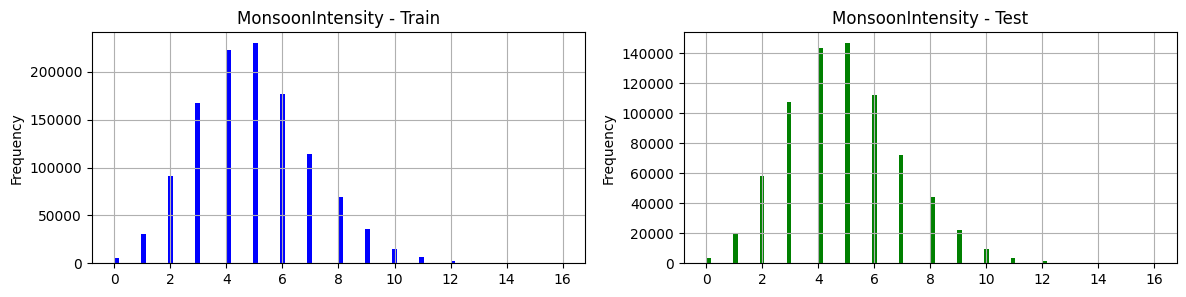

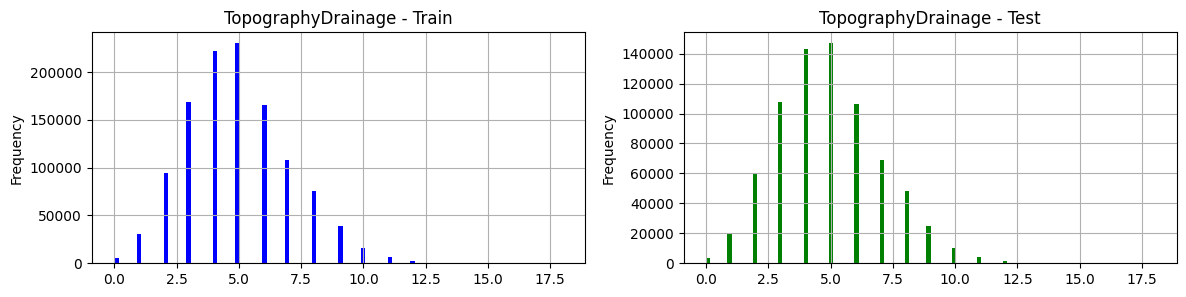

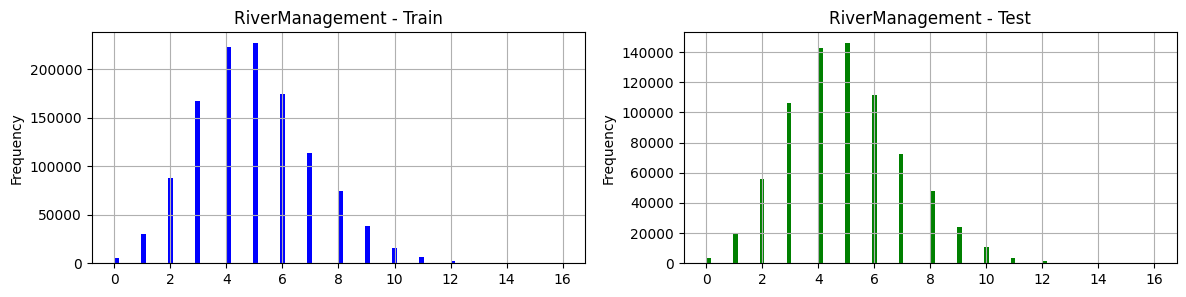

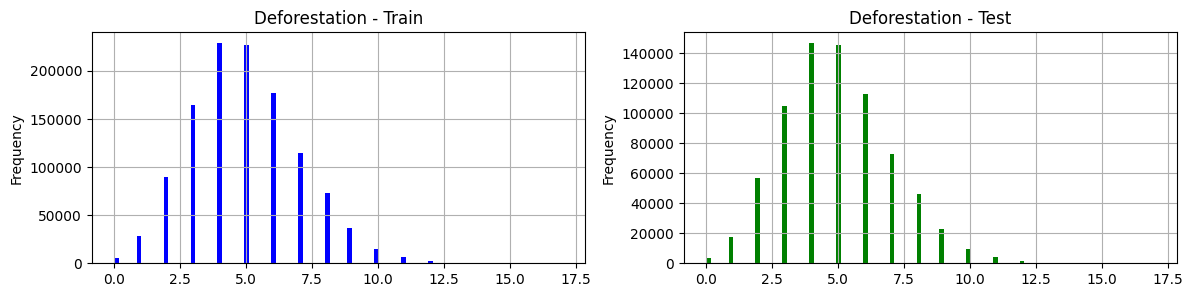

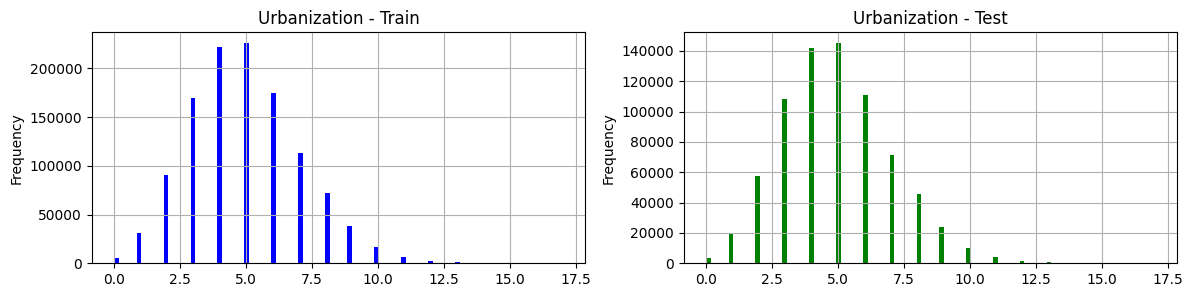

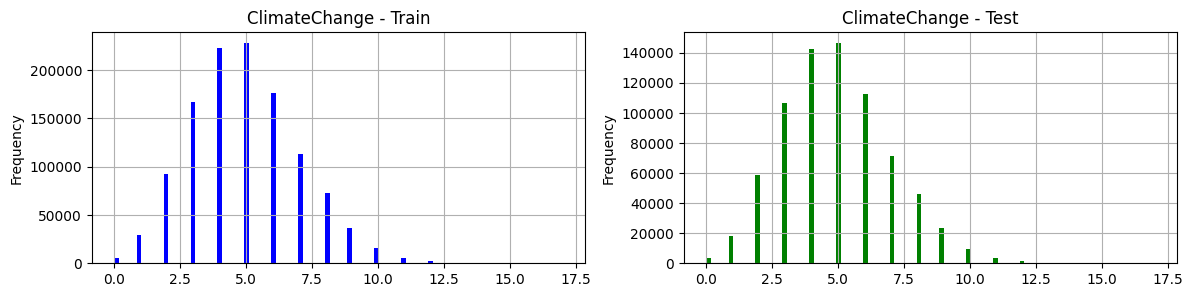

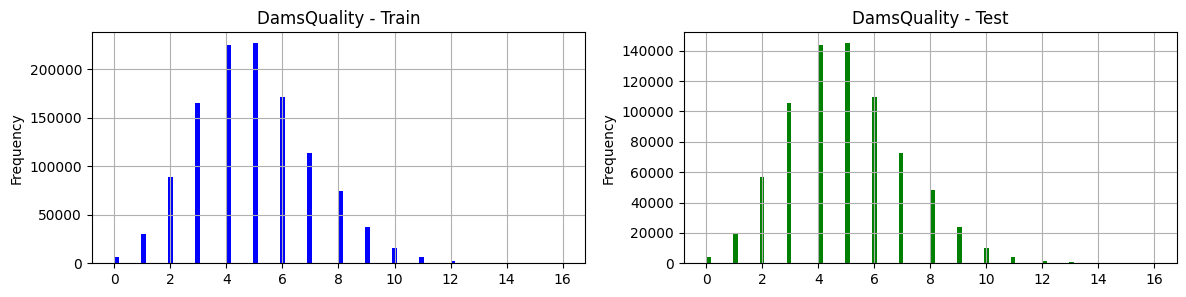

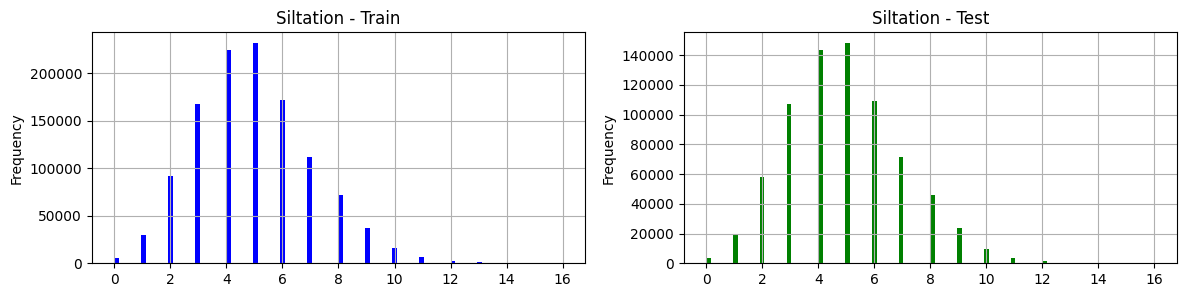

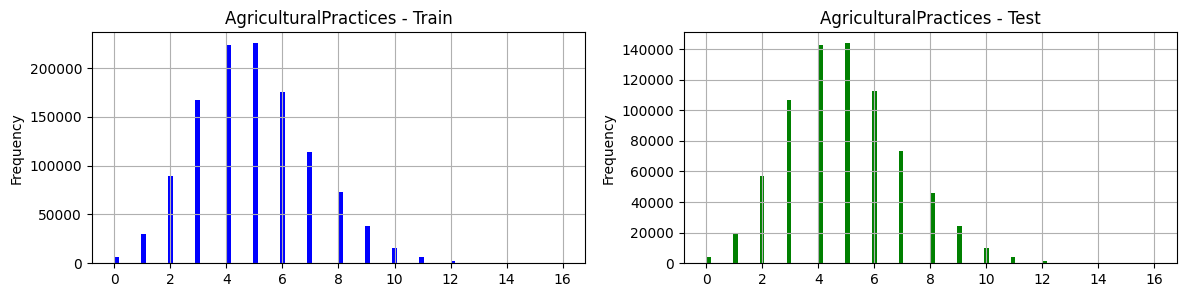

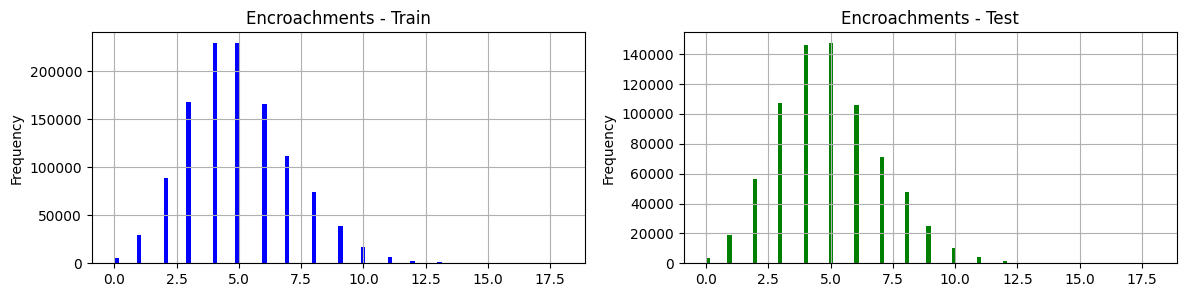

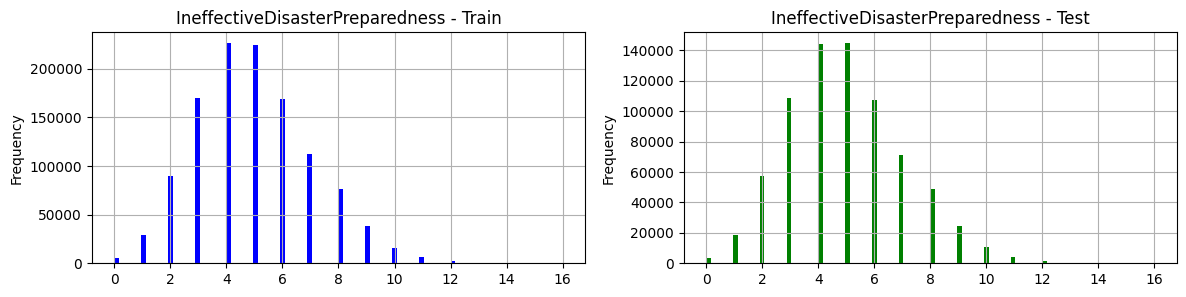

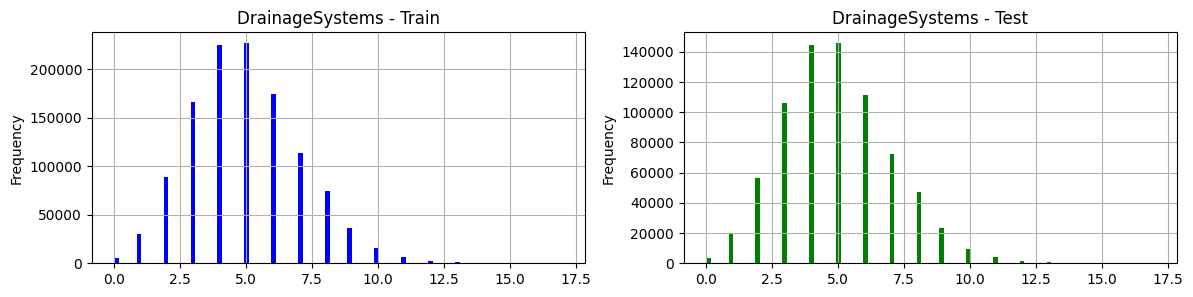

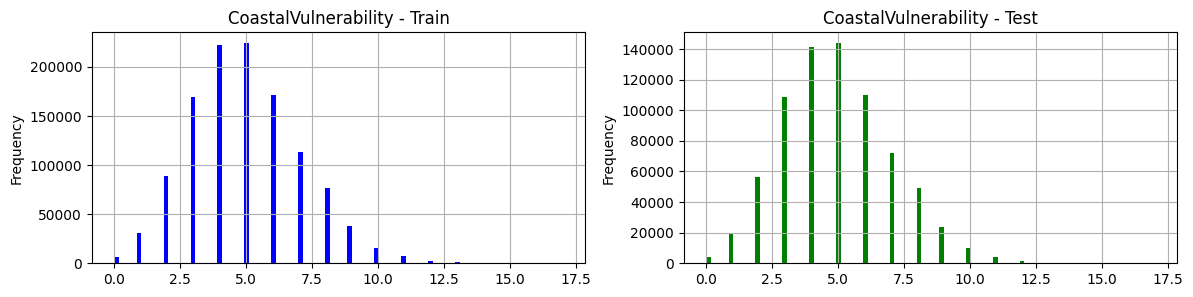

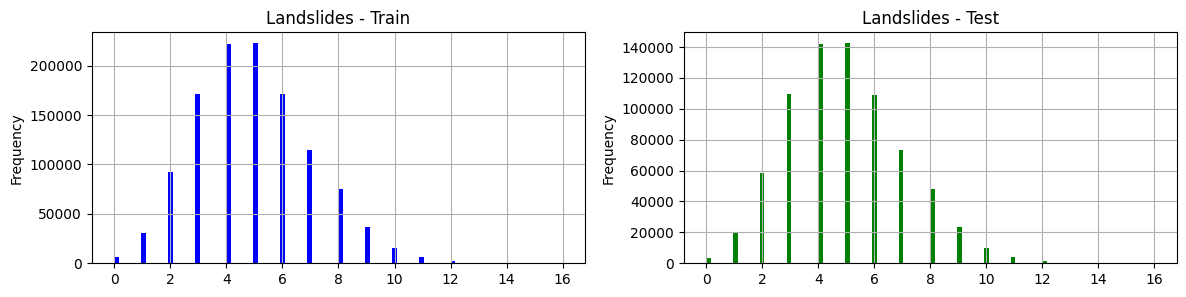

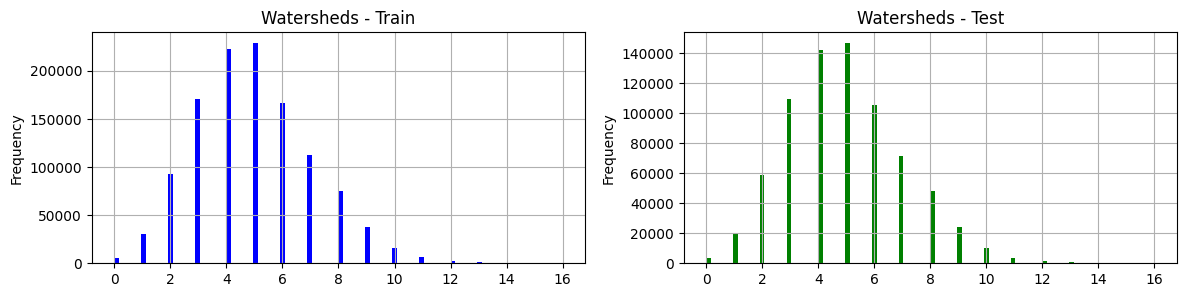

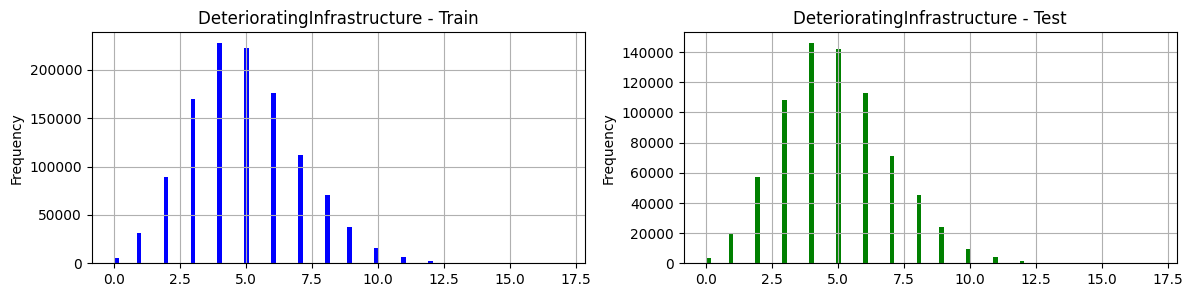

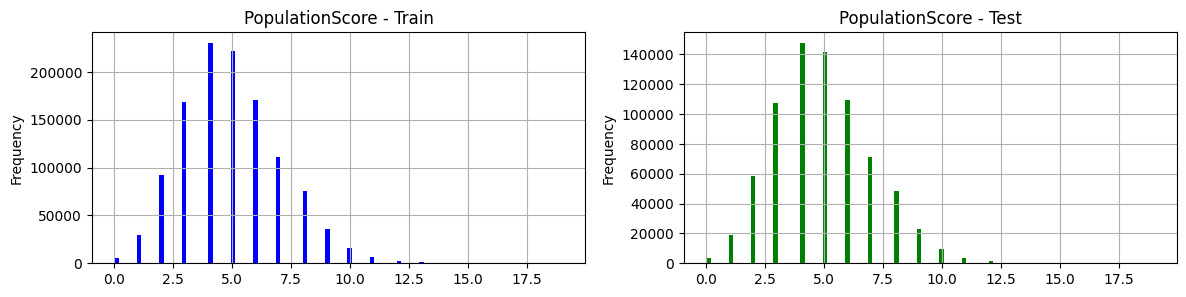

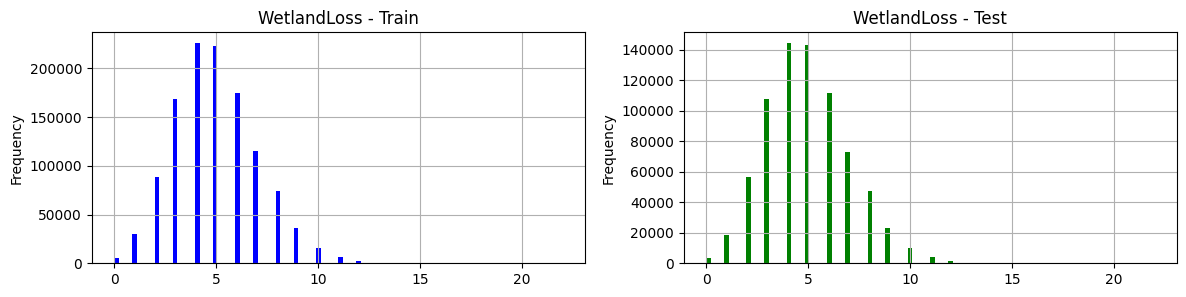

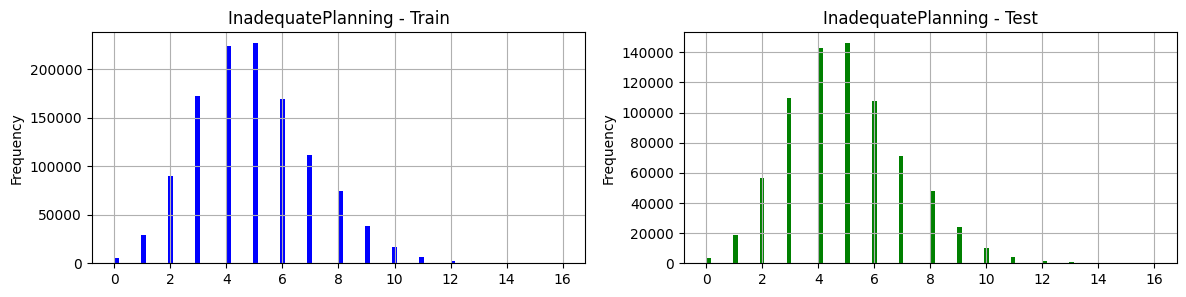

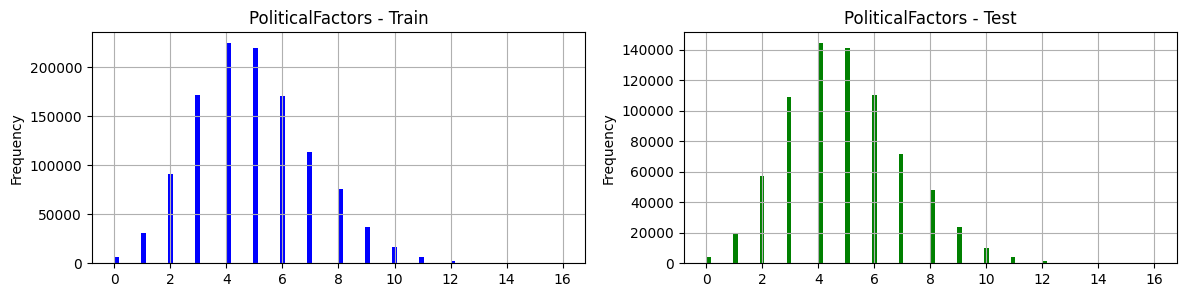

In [ ]:
for f in cat_features:
    plt.figure(figsize=(14,3))
    ax1 = plt.subplot(1,2,1)
    df_combined[f].plot(kind='hist', bins=100, color="blue")
    plt.title(f + ' - Train')
    plt.grid()
    ax2 = plt.subplot(1,2,2, sharex=ax1)
    df_test[f].plot(kind='hist', bins=100, color="green")
    plt.title(f + ' - Test')
    plt.grid()
    plt.show()

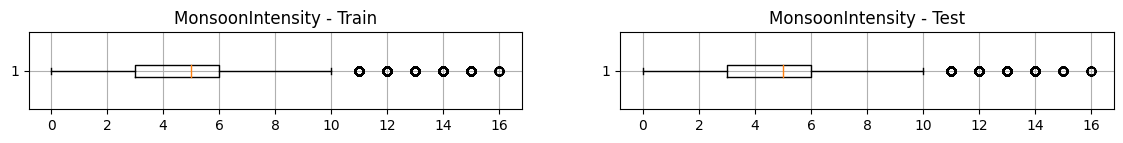

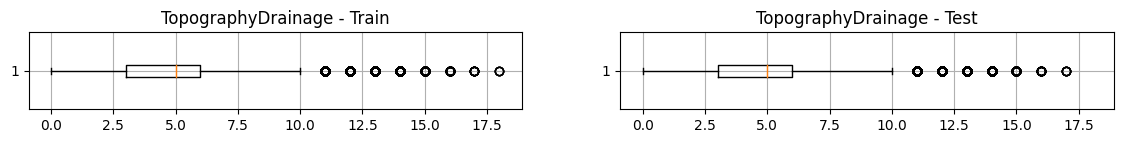

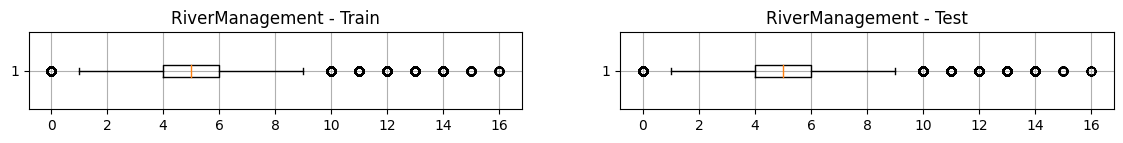

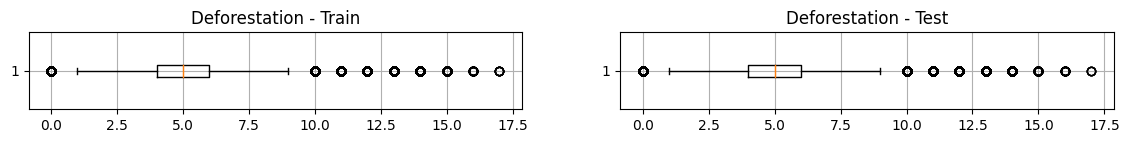

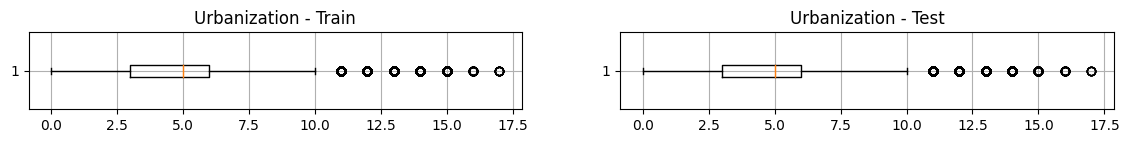

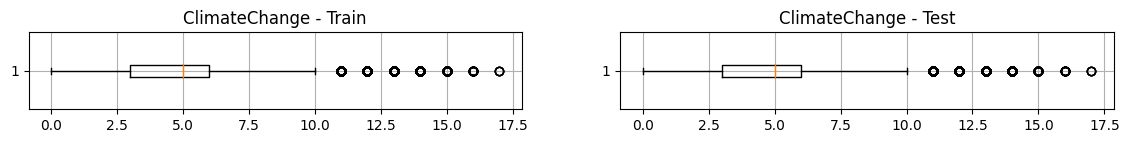

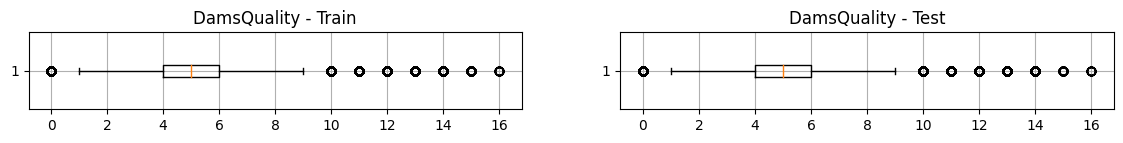

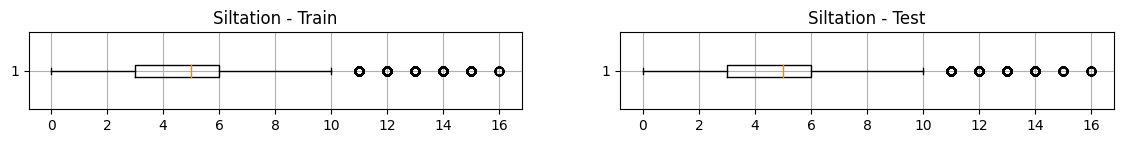

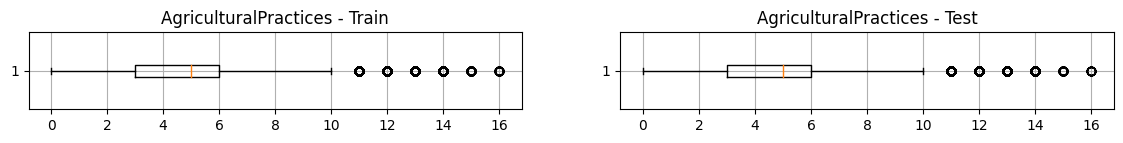

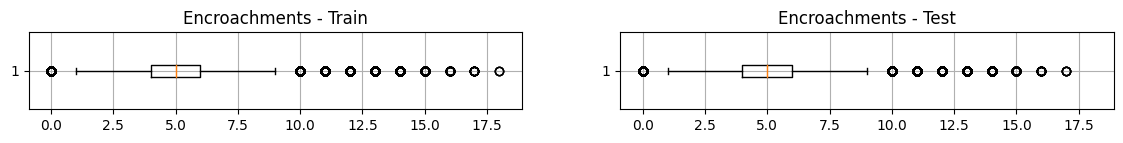

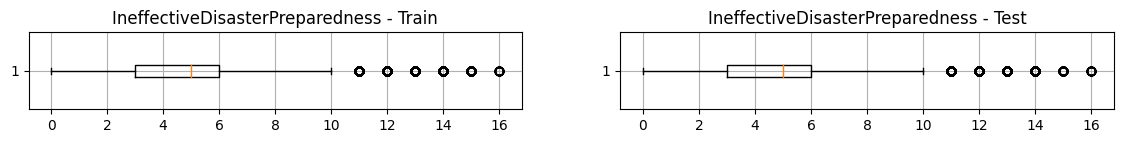

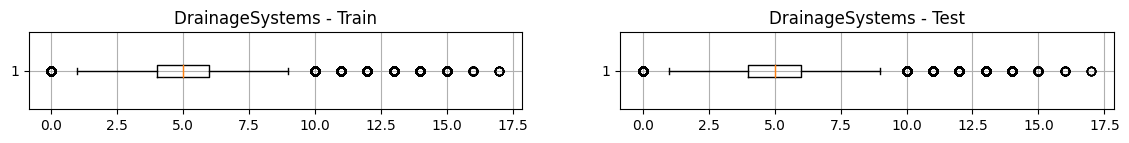

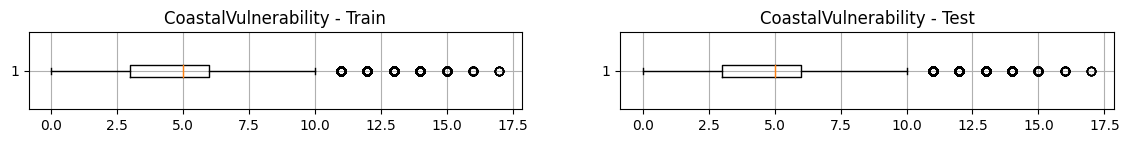

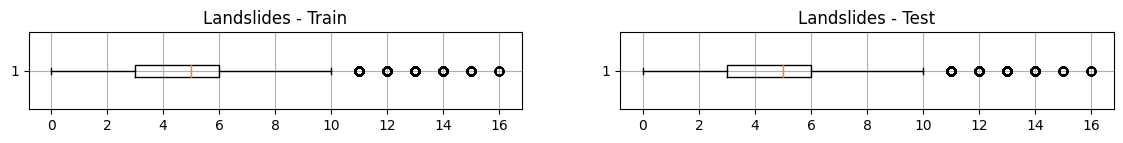

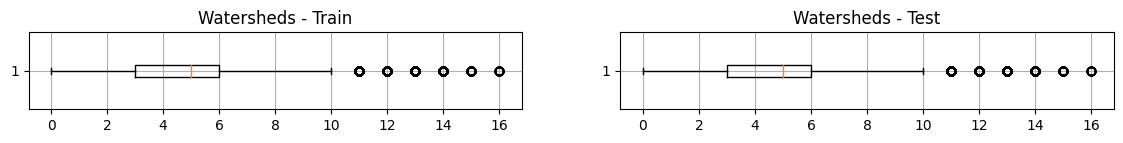

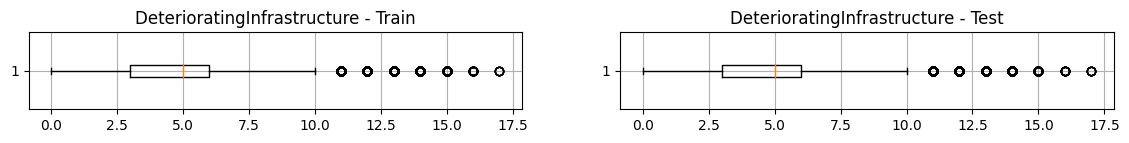

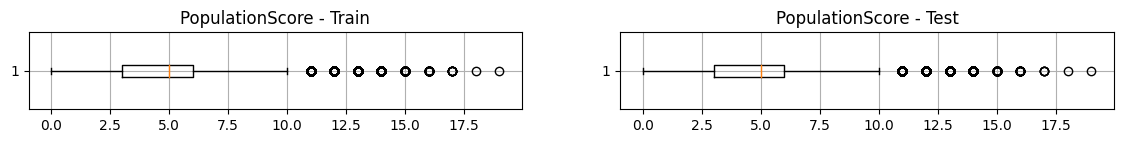

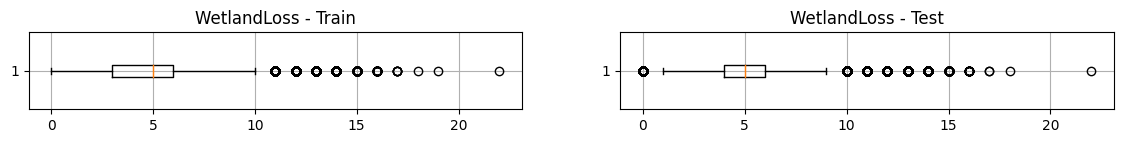

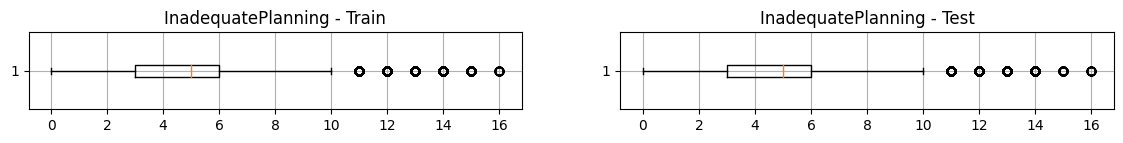

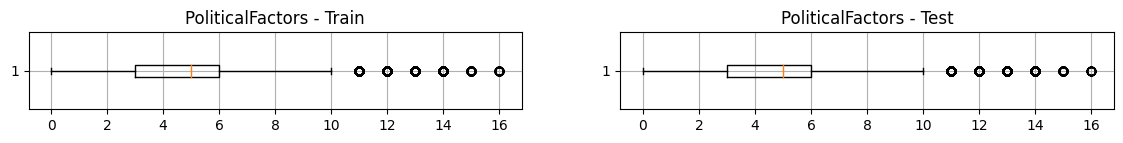

In [ ]:
for f in cat_features:
    plt.figure(figsize=(14,1))
    ax1 = plt.subplot(1,2,1)
    df_temp = df_combined[f].dropna() # boxplot does not like missings...
    plt.boxplot(df_temp, vert=False)
    plt.title(f + ' - Train')
    plt.grid()
    ax2 = plt.subplot(1,2,2, sharex=ax1)
    df_temp = df_test[f].dropna()
    plt.boxplot(df_temp, vert=False)
    plt.title(f + ' - Test')
    plt.grid()
    plt.show()

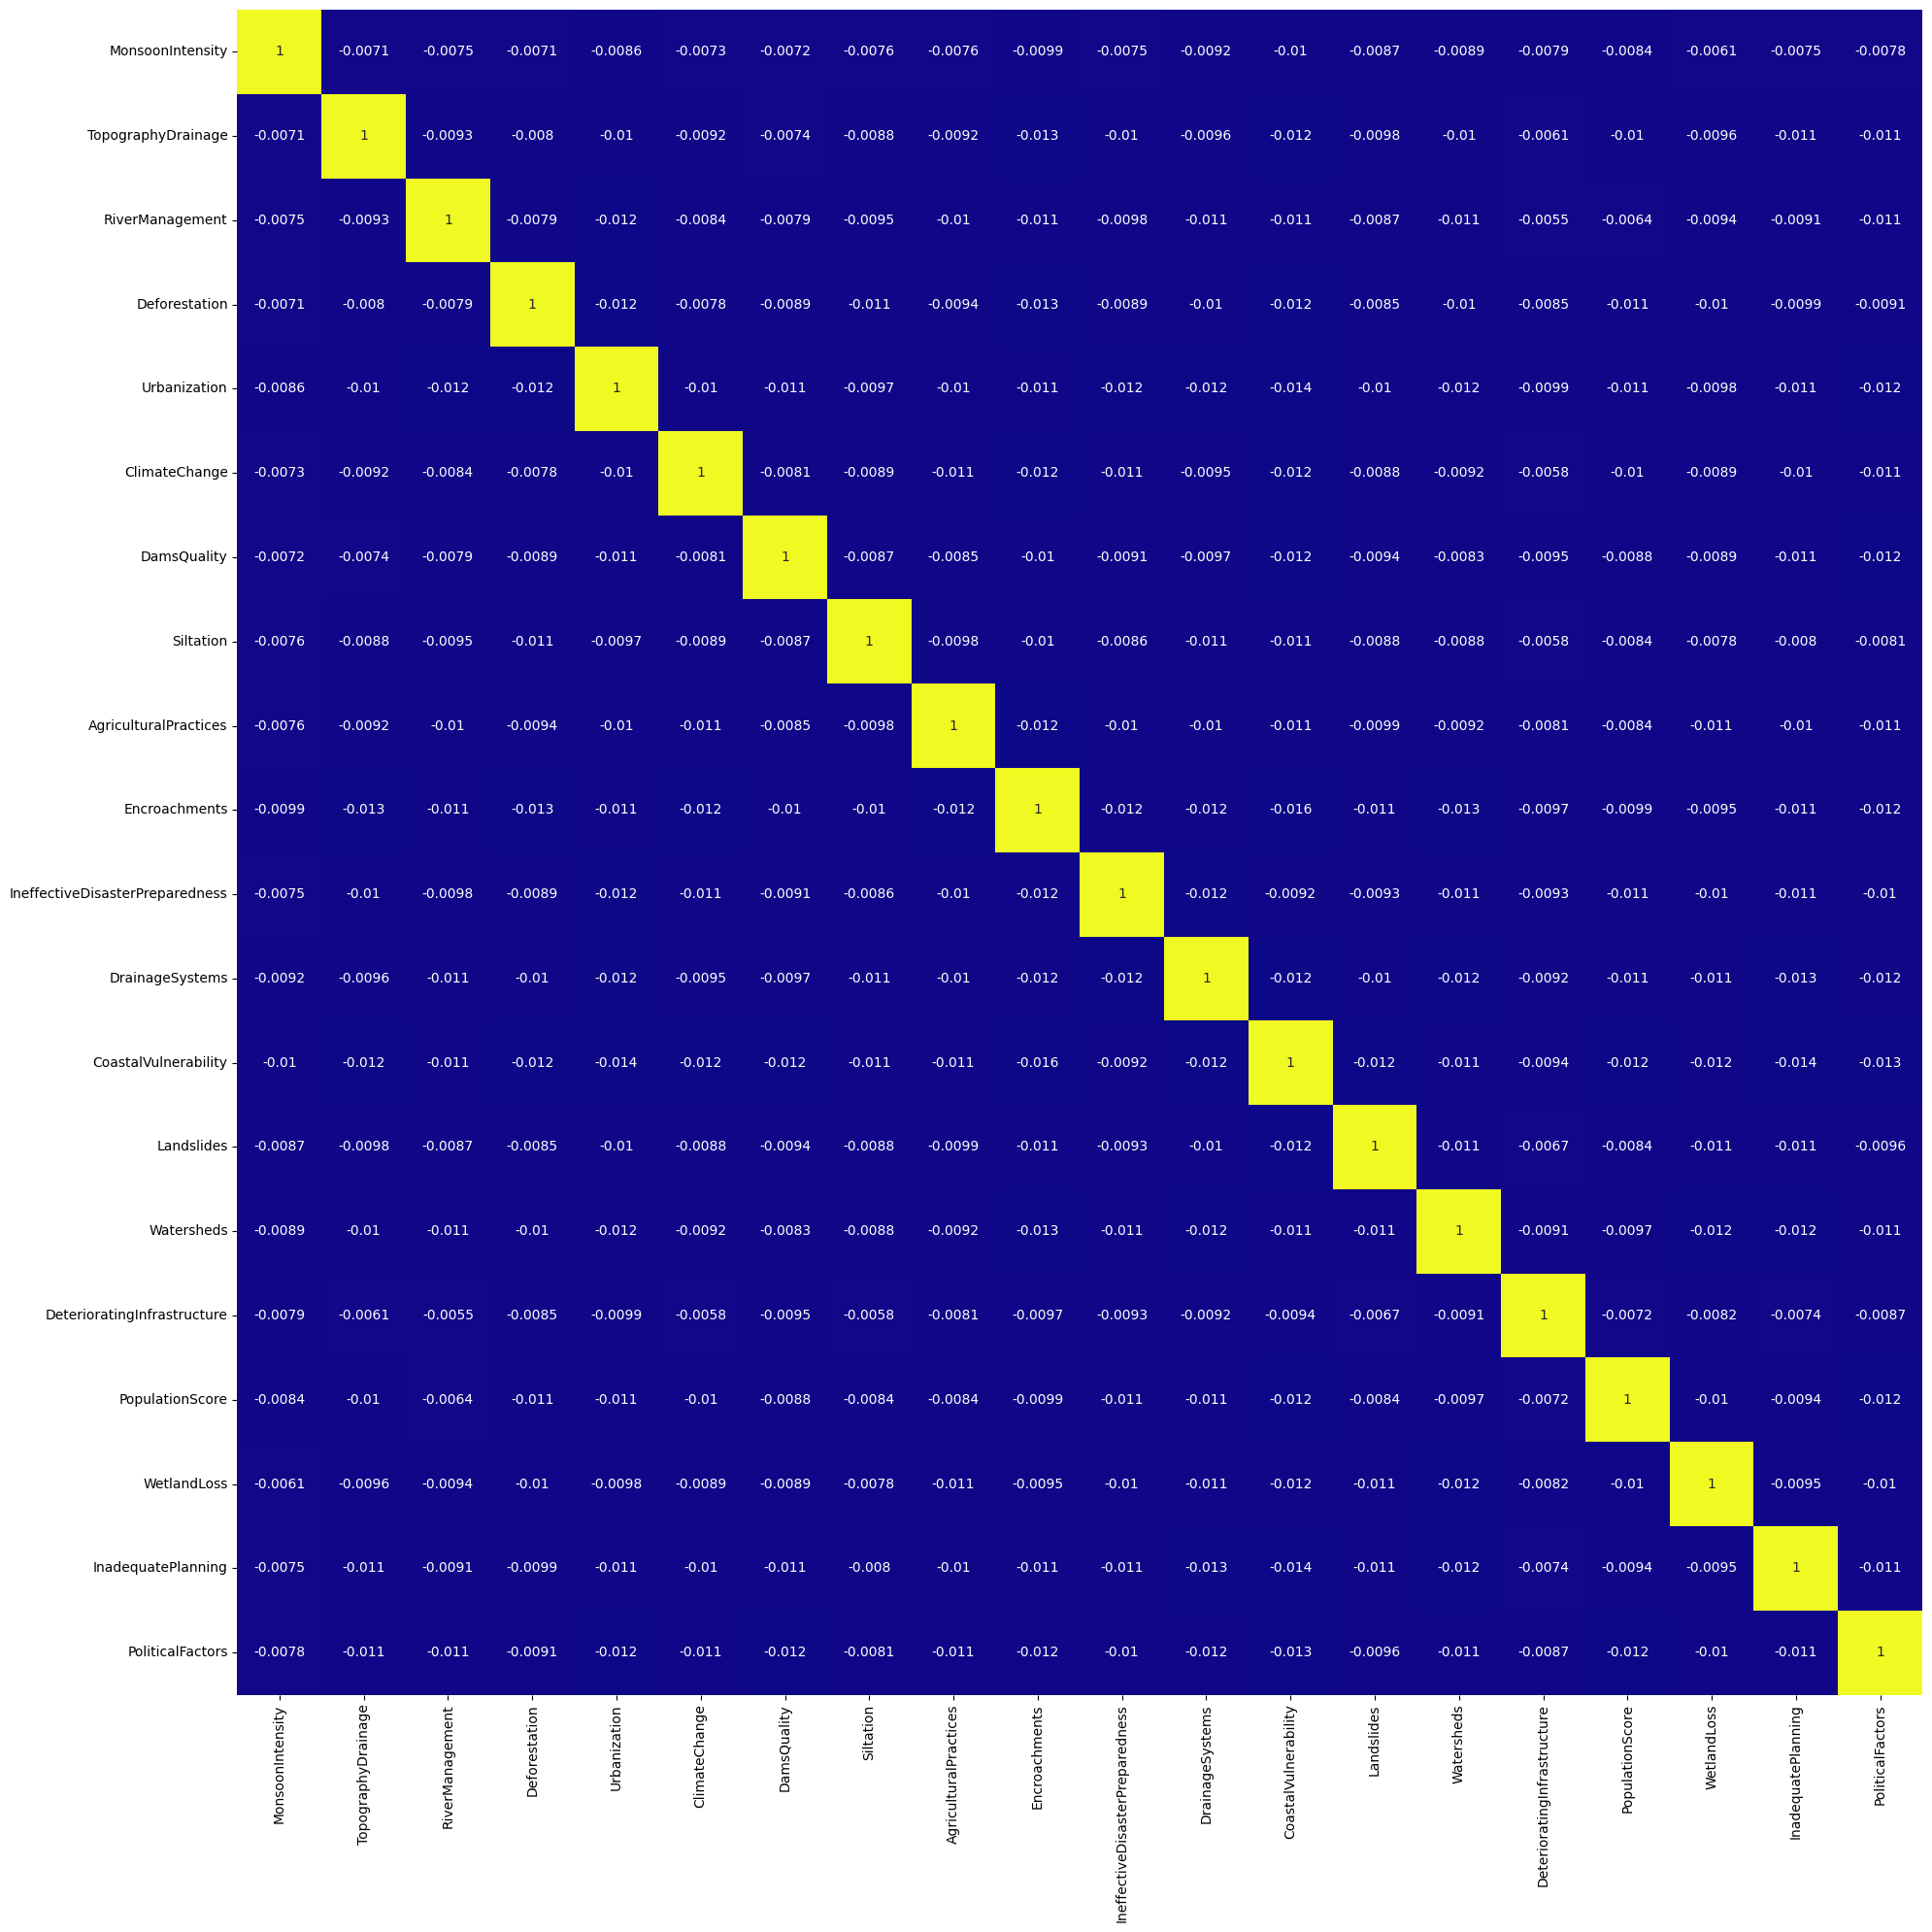

In [ ]:
plt.figure(figsize=(20,20))
corr_matrix = df_combined[cat_features].corr(method="pearson")
sns.heatmap(corr_matrix, annot=True,cmap="plasma", cbar=None)
plt.tight_layout()
plt.show()

In [ ]:
target = "FloodProbability"

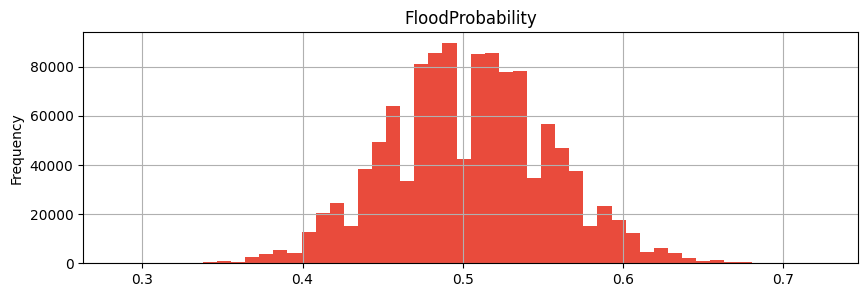

count    1.167957e+06
mean     5.042740e-01
std      5.099335e-02
min      2.850000e-01
25%      4.700000e-01
50%      5.050000e-01
75%      5.400000e-01
max      7.250000e-01
Name: FloodProbability, dtype: float64


In [ ]:
plt.figure(figsize=(10,3))
df_combined[target].plot(kind='hist', bins=50, color="#E94B3CFF")
plt.title(target)
plt.grid()
plt.show()
print(df_combined[target].describe().T)

In [ ]:
cat_features

['MonsoonIntensity',
 'TopographyDrainage',
 'RiverManagement',
 'Deforestation',
 'Urbanization',
 'ClimateChange',
 'DamsQuality',
 'Siltation',
 'AgriculturalPractices',
 'Encroachments',
 'IneffectiveDisasterPreparedness',
 'DrainageSystems',
 'CoastalVulnerability',
 'Landslides',
 'Watersheds',
 'DeterioratingInfrastructure',
 'PopulationScore',
 'WetlandLoss',
 'InadequatePlanning',
 'PoliticalFactors']

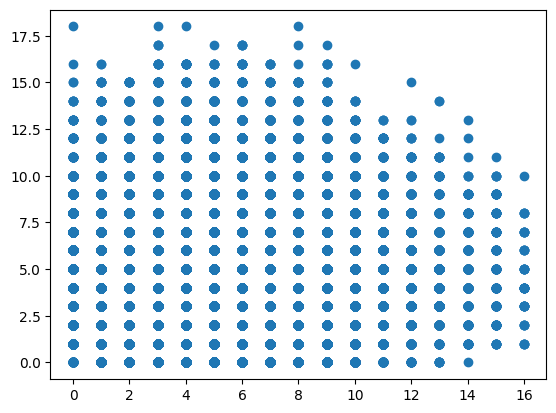

In [ ]:
plt.scatter(df_combined["MonsoonIntensity"], df_combined["TopographyDrainage"])
plt.show()

<Figure size 1400x300 with 0 Axes>

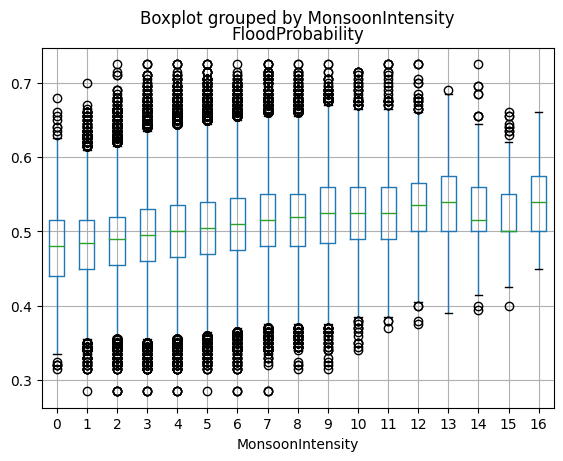

<Figure size 1400x300 with 0 Axes>

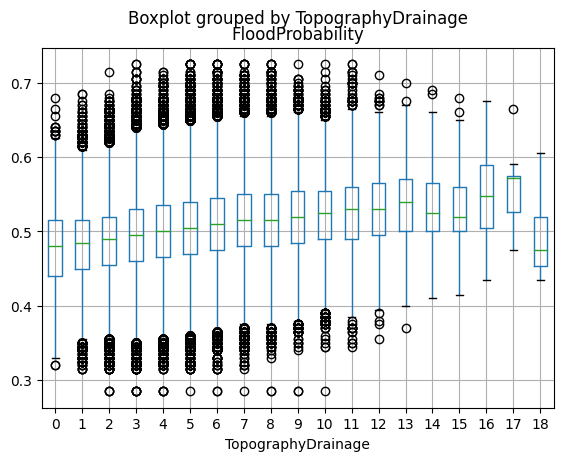

<Figure size 1400x300 with 0 Axes>

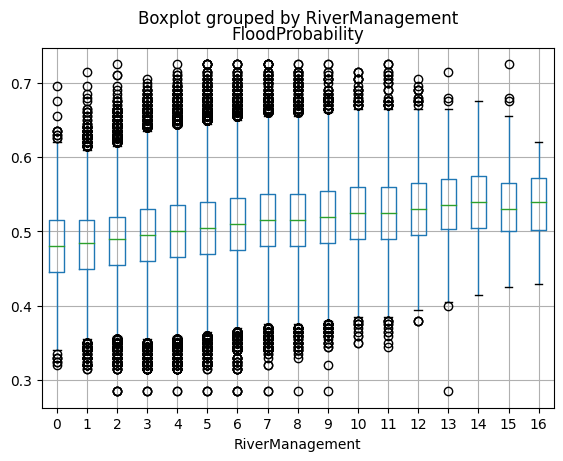

<Figure size 1400x300 with 0 Axes>

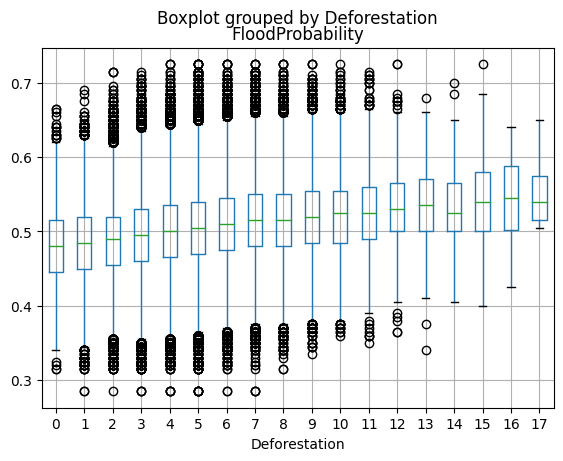

<Figure size 1400x300 with 0 Axes>

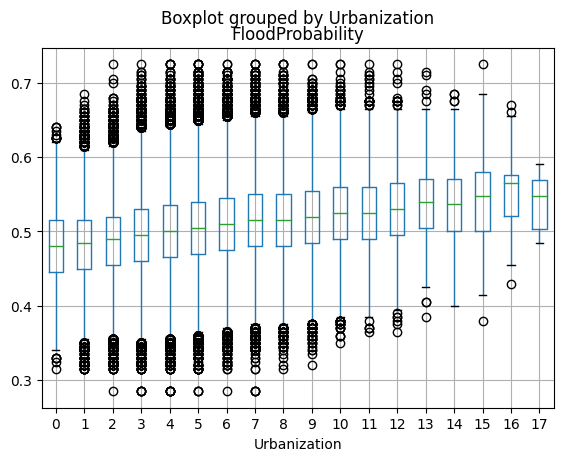

<Figure size 1400x300 with 0 Axes>

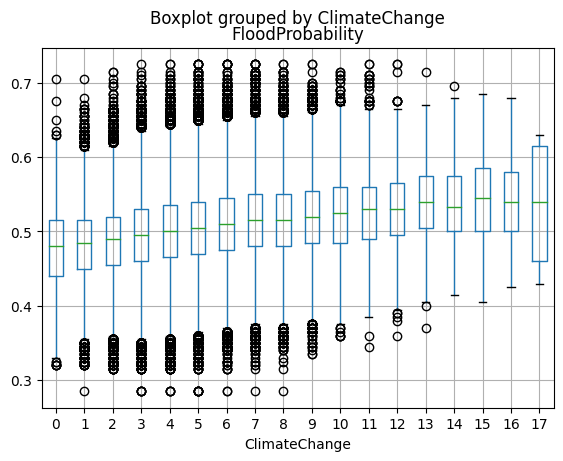

<Figure size 1400x300 with 0 Axes>

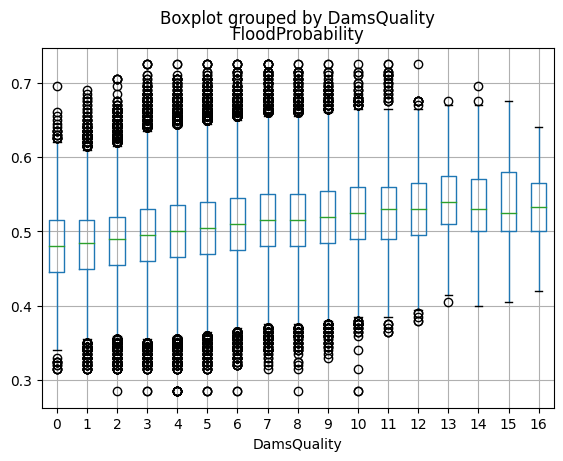

<Figure size 1400x300 with 0 Axes>

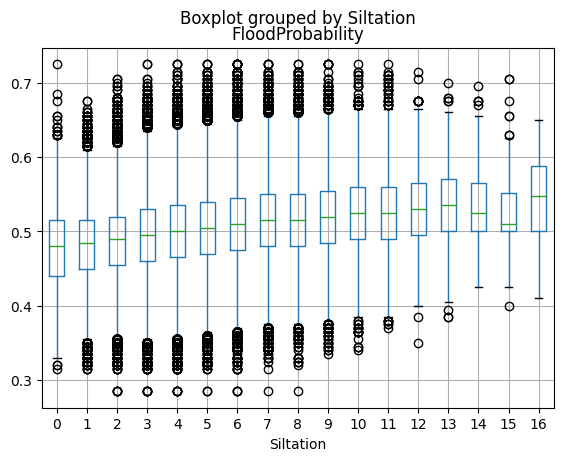

<Figure size 1400x300 with 0 Axes>

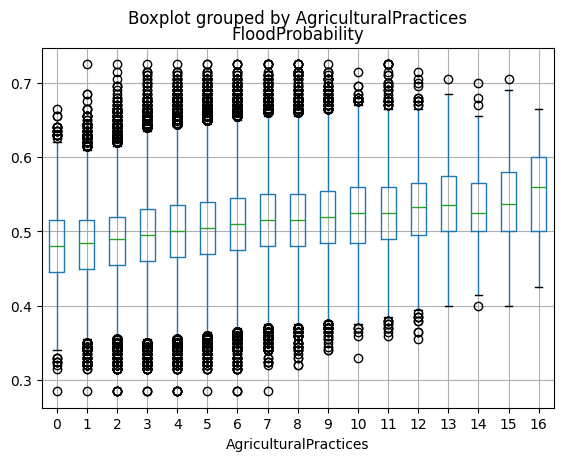

<Figure size 1400x300 with 0 Axes>

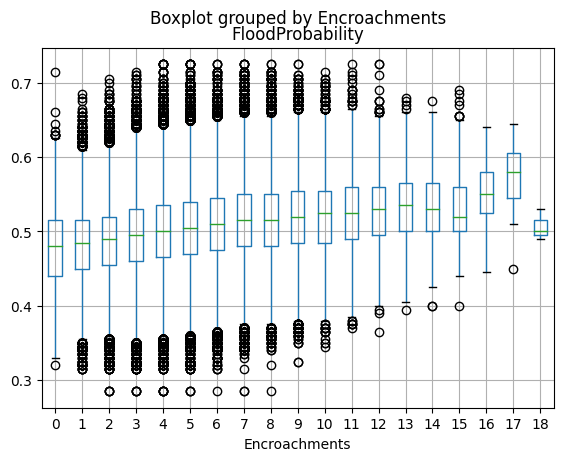

<Figure size 1400x300 with 0 Axes>

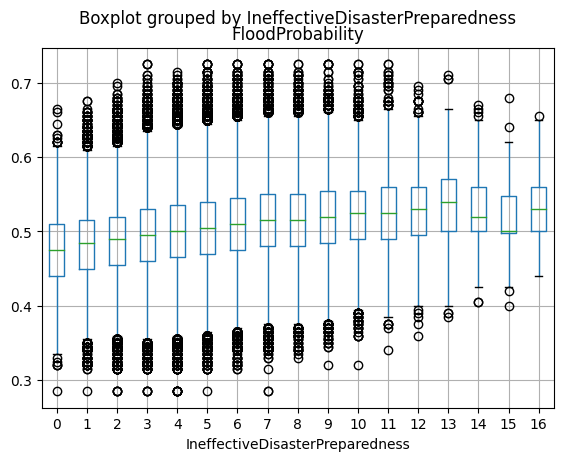

<Figure size 1400x300 with 0 Axes>

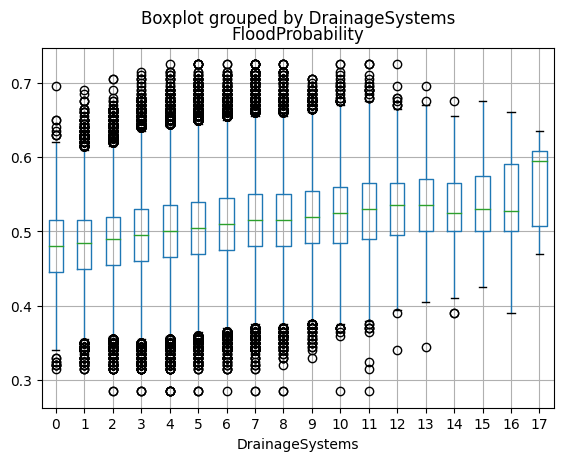

<Figure size 1400x300 with 0 Axes>

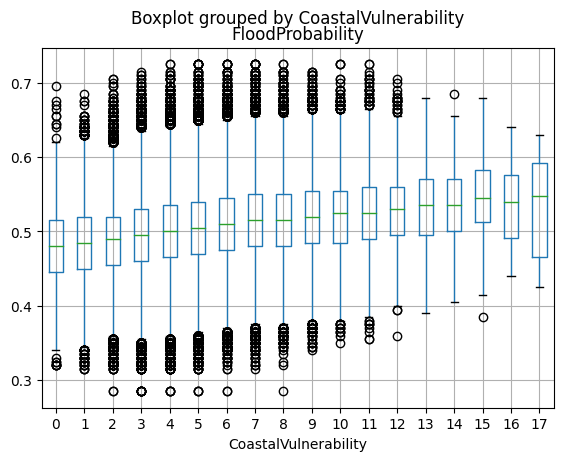

<Figure size 1400x300 with 0 Axes>

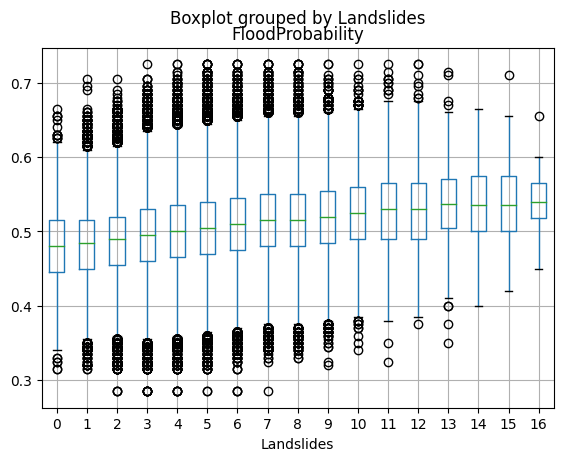

<Figure size 1400x300 with 0 Axes>

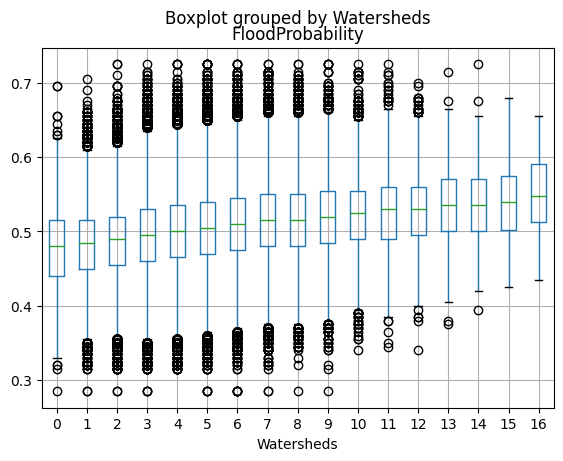

<Figure size 1400x300 with 0 Axes>

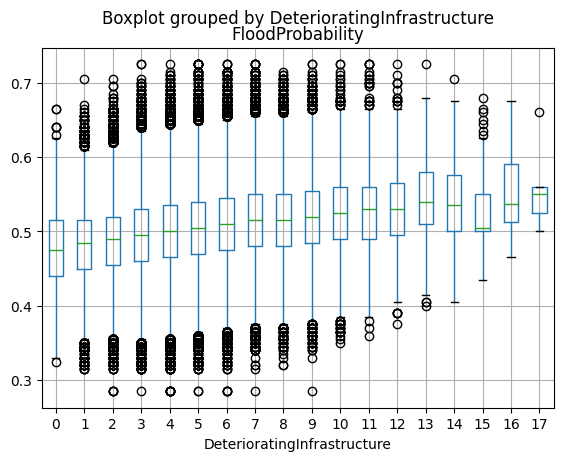

<Figure size 1400x300 with 0 Axes>

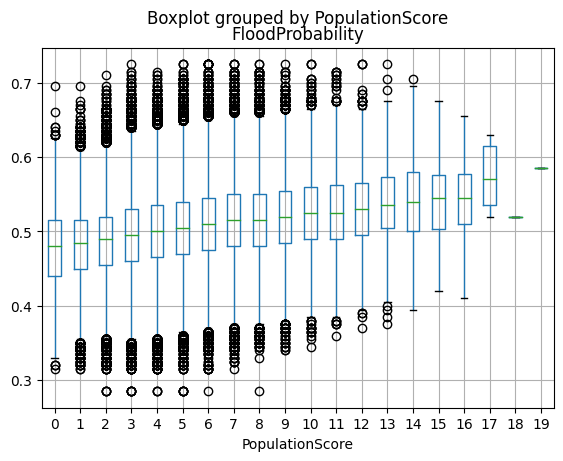

<Figure size 1400x300 with 0 Axes>

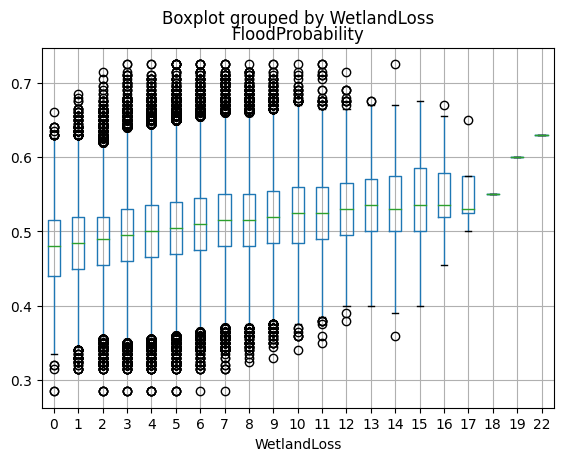

<Figure size 1400x300 with 0 Axes>

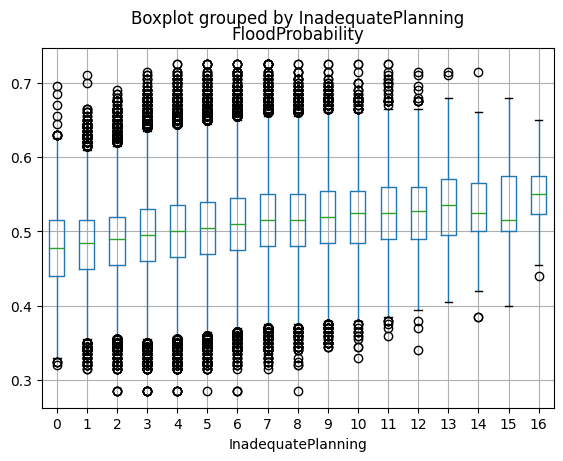

<Figure size 1400x300 with 0 Axes>

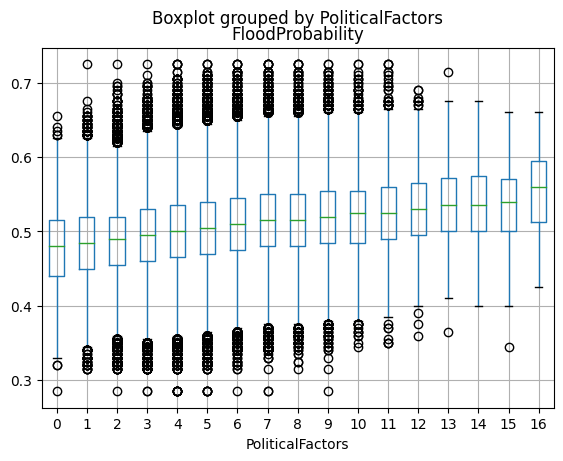

In [ ]:
for f in cat_features:
    plt.figure(figsize=(14,3))
    df_combined.boxplot(column = target, by = f)
    plt.show()

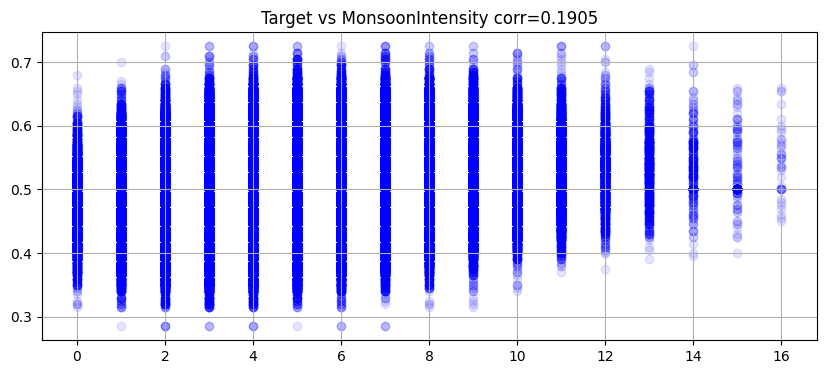

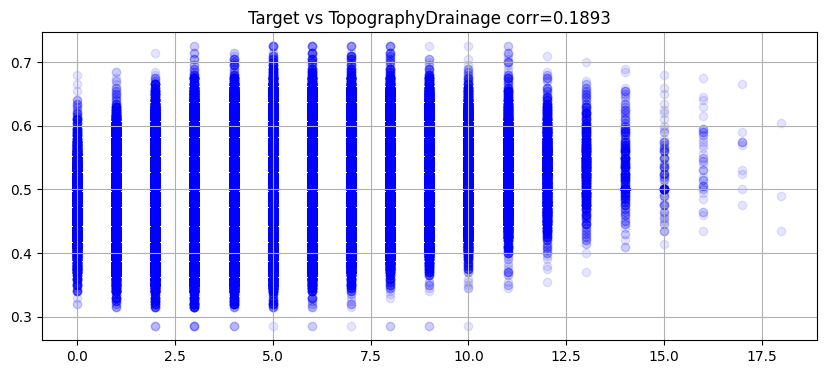

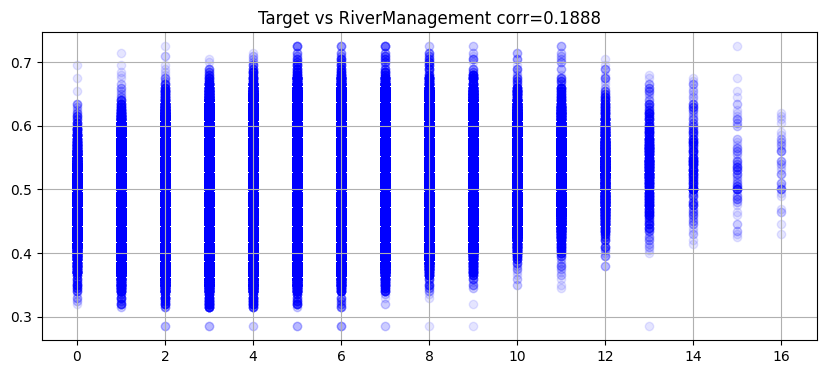

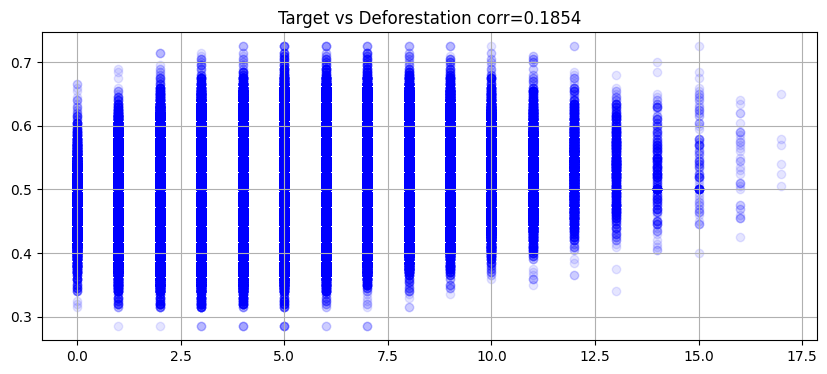

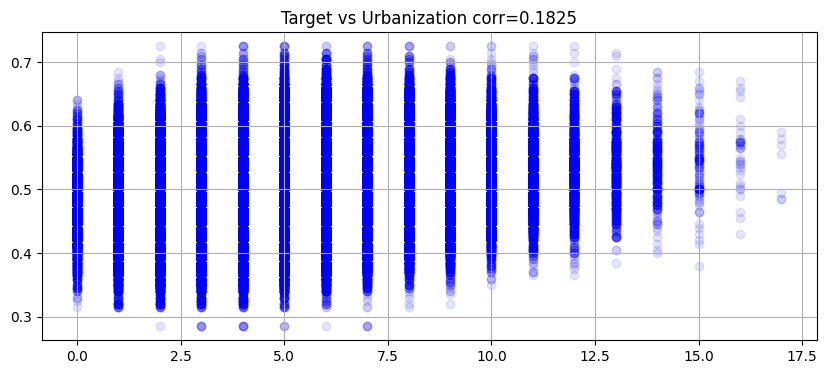

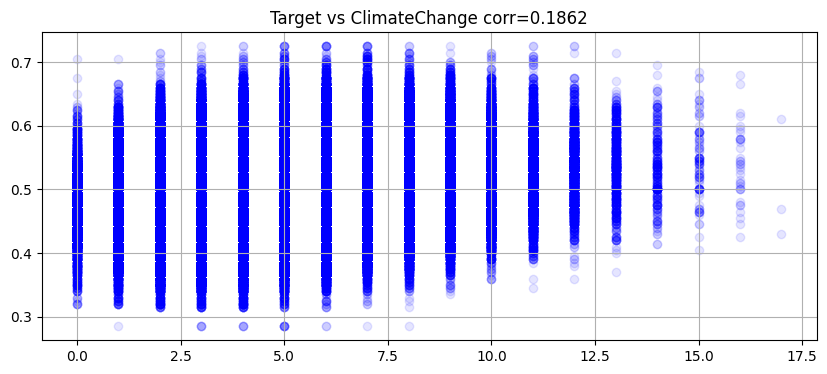

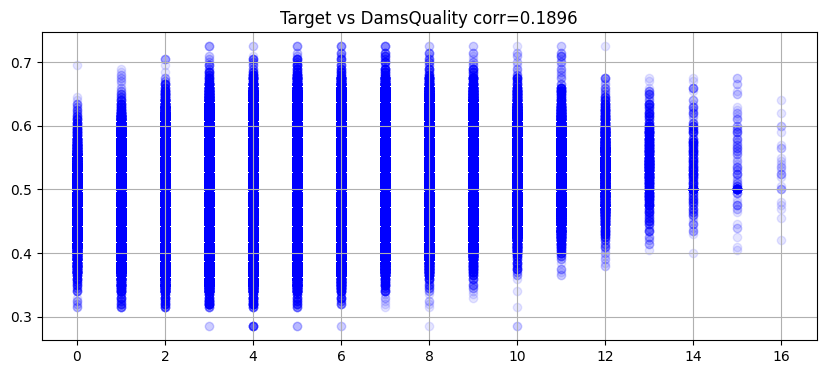

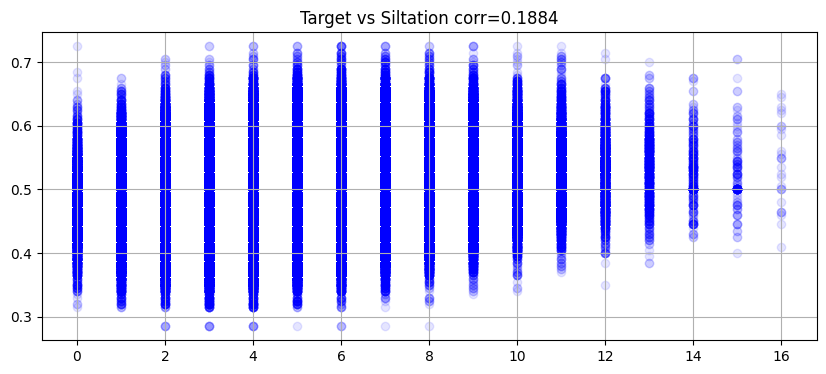

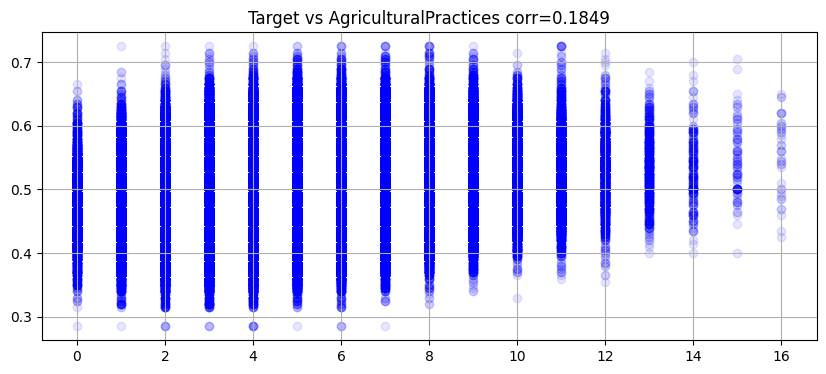

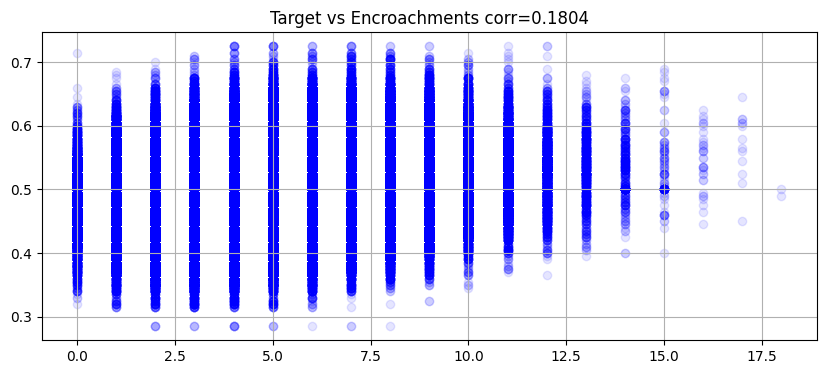

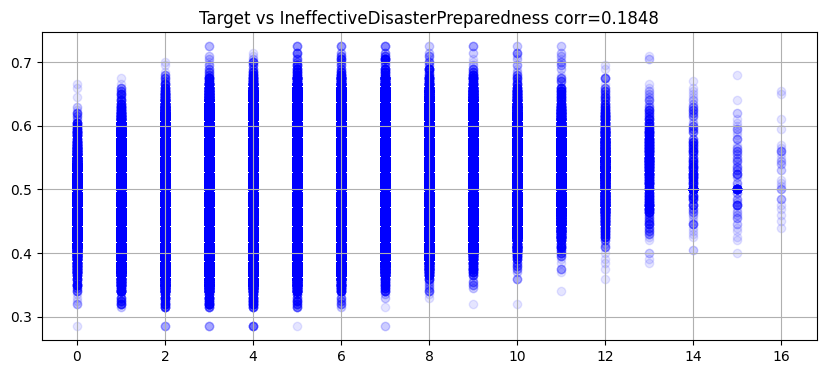

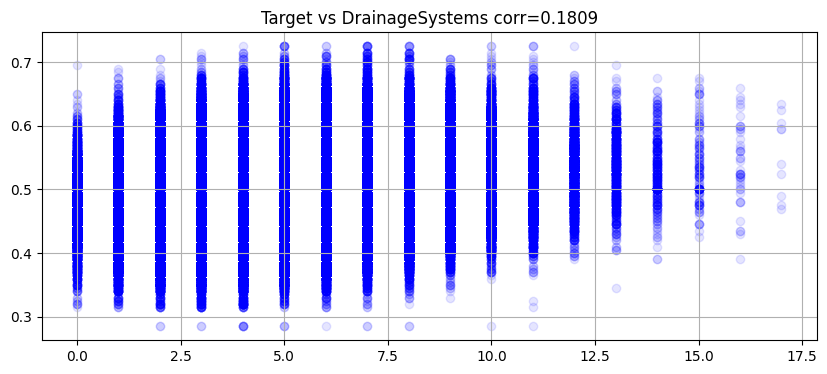

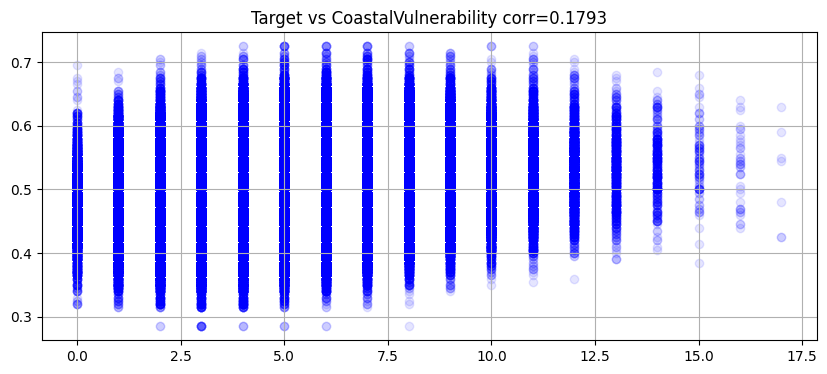

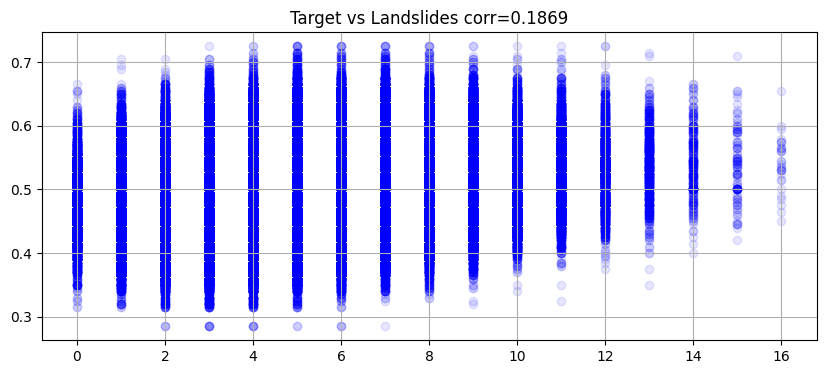

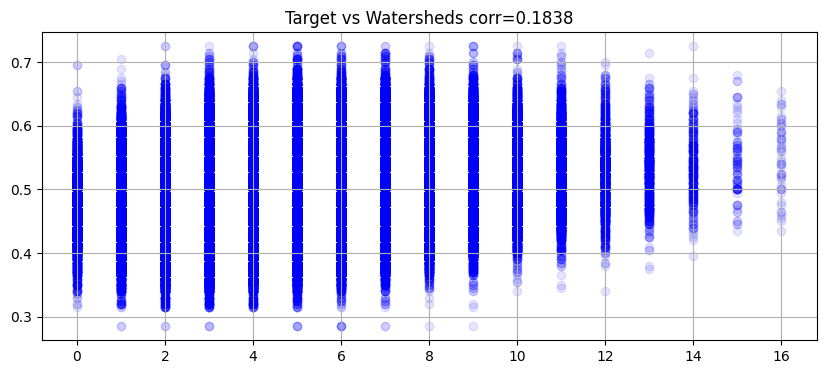

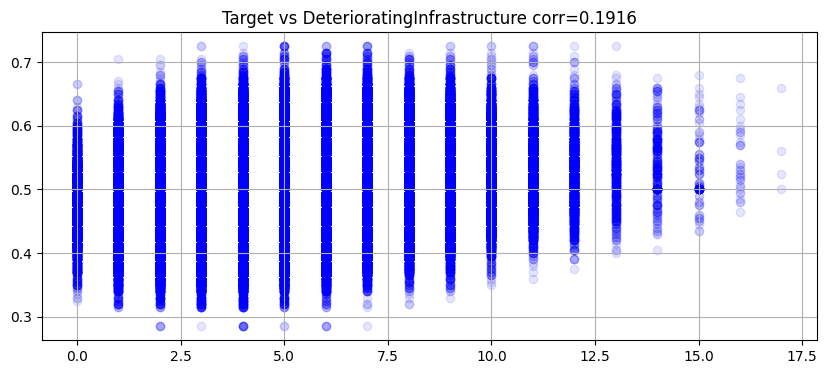

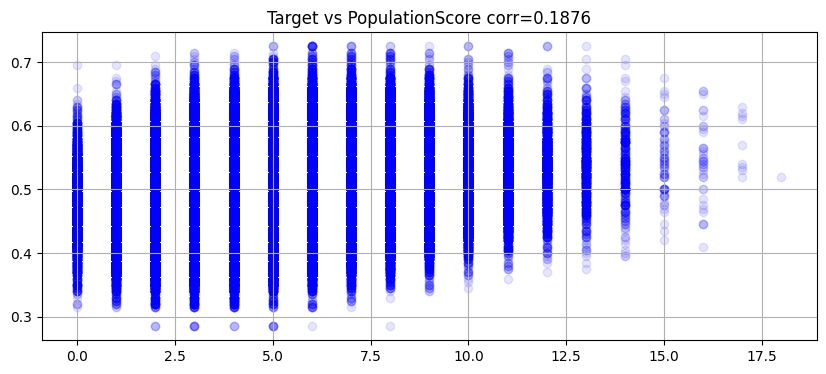

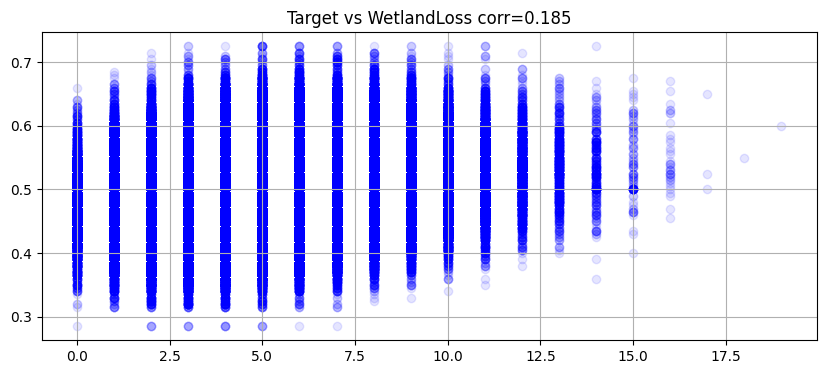

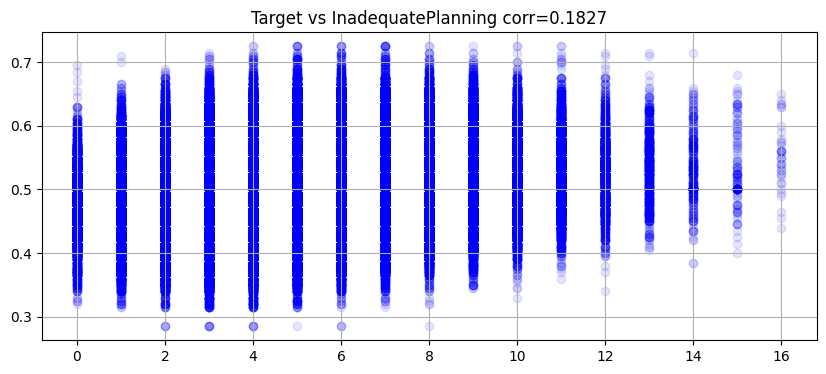

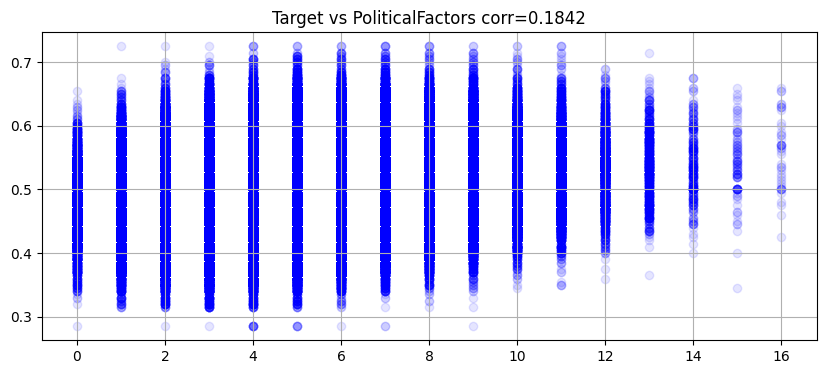

In [ ]:
for f in cat_features:
    if (f in cat_features):
        c = df_combined[target].corr(df_combined[f])
        plt.figure(figsize=(10,4))
        plt.scatter(df_train[f], df_train[target],
                    color="blue", alpha=0.1)
        plt.title('Target vs ' + f + ' corr=' + str(np.round(c,4)))
        plt.grid()
        plt.show()
    else:
        plt.figure(figsize=(10,4))
        # pick only to most frequent levels
        most_freq = df_combined[f].value_counts().index[0:22].tolist()
        df_temp = df_combined[df_combined[f].isin(most_freq)]
        sns.violinplot(data=df_temp, x=f, y=target)
        plt.title('Target vs ' + f + ' (most frequent levels only)')
        plt.grid()
        plt.show()

In [ ]:
# Split the train data into X and y
X = df_combined.drop(target, axis=1)
y = df_combined.FloodProbability

In [ ]:
%%time
# Running non tuned cat boost model to get feature importance
best_cat = CatBoostRegressor(random_state=27)

best_cat.fit(X, y)

Learning rate set to 0.124978
0:	learn: 0.0500852	total: 260ms	remaining: 4m 20s
1:	learn: 0.0491846	total: 451ms	remaining: 3m 45s
2:	learn: 0.0482825	total: 644ms	remaining: 3m 33s
3:	learn: 0.0474705	total: 818ms	remaining: 3m 23s
4:	learn: 0.0466906	total: 986ms	remaining: 3m 16s
5:	learn: 0.0459228	total: 1.16s	remaining: 3m 12s
6:	learn: 0.0451907	total: 1.33s	remaining: 3m 8s
7:	learn: 0.0445132	total: 1.5s	remaining: 3m 6s
8:	learn: 0.0438386	total: 1.69s	remaining: 3m 6s
9:	learn: 0.0431741	total: 1.87s	remaining: 3m 4s
10:	learn: 0.0425871	total: 2.03s	remaining: 3m 2s
11:	learn: 0.0419977	total: 2.19s	remaining: 3m
12:	learn: 0.0414196	total: 2.36s	remaining: 2m 58s
13:	learn: 0.0408611	total: 2.51s	remaining: 2m 56s
14:	learn: 0.0403253	total: 2.96s	remaining: 3m 14s
15:	learn: 0.0397815	total: 3.28s	remaining: 3m 21s
16:	learn: 0.0392538	total: 3.43s	remaining: 3m 18s
17:	learn: 0.0387648	total: 3.59s	remaining: 3m 15s
18:	learn: 0.0382793	total: 3.97s	remaining: 3m 24s
19

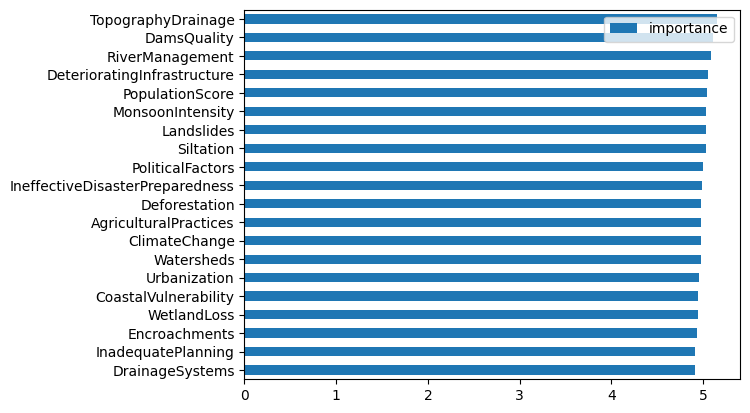

In [ ]:
importance = best_cat.feature_importances_

feature_importance = pd.DataFrame(data=importance, index=X.columns, columns=['importance']).sort_values(ascending=True, by='importance')

feature_importance.plot(kind='barh')
plt.show()

In [ ]:
%%time
def objective(trial):
    model = CatBoostRegressor(
        iterations=trial.suggest_int("iterations", 100, 1000),
        learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        # colsample_bylevel=trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        min_data_in_leaf=trial.suggest_int("min_data_in_leaf", 1, 100),
        depth=trial.suggest_int("depth", 2, 16),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        verbose=False,
        random_state=27,
        task_type='GPU'
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return np.sqrt(r2_score(y_test, y_pred))

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 5.96 µs


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)

In [ ]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = TPESampler(seed=27)
study = optuna.create_study(study_name="catboost", direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=20)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print(" Value: ", trial.value)
print(" Params: ")

for key, value in trial.params.items():
    print(f"    {key}: {value}")
print("*"*100)

Number of finished trials:  20
Best trial:
 Value:  0.9226501023653222
 Params: 
    iterations: 716
    learning_rate: 0.09423155164094112
    min_data_in_leaf: 3
    depth: 10
    l2_leaf_reg: 0.009906225212904752
****************************************************************************************************


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=27)

In [ ]:
model1 = CatBoostRegressor(
    iterations=716,
    learning_rate=0.09423155164094112,
    min_data_in_leaf=3,
    depth=10,
    l2_leaf_reg=0.009906225212904752,
)

model2 = CatBoostRegressor(
    iterations=716,
    learning_rate=0.09423155164094112,
    colsample_bylevel=0.32374524982071545,
    min_data_in_leaf=3,
    depth=10,
    l2_leaf_reg=0.009906225212904752,
)

In [ ]:
model1.fit(X_train, y_train)
model2.fit(X_train, y_train)

0:	learn: 0.0498233	total: 301ms	remaining: 3m 35s
1:	learn: 0.0486754	total: 603ms	remaining: 3m 35s
2:	learn: 0.0476223	total: 908ms	remaining: 3m 35s
3:	learn: 0.0466083	total: 1.22s	remaining: 3m 36s
4:	learn: 0.0456651	total: 1.51s	remaining: 3m 35s
5:	learn: 0.0447299	total: 1.81s	remaining: 3m 34s
6:	learn: 0.0439016	total: 2.13s	remaining: 3m 35s
7:	learn: 0.0430832	total: 2.43s	remaining: 3m 35s
8:	learn: 0.0423231	total: 2.75s	remaining: 3m 35s
9:	learn: 0.0415782	total: 3.12s	remaining: 3m 40s
10:	learn: 0.0408610	total: 3.68s	remaining: 3m 55s
11:	learn: 0.0401694	total: 4.24s	remaining: 4m 8s
12:	learn: 0.0395211	total: 4.82s	remaining: 4m 20s
13:	learn: 0.0388690	total: 5.39s	remaining: 4m 30s
14:	learn: 0.0382705	total: 5.91s	remaining: 4m 36s
15:	learn: 0.0376753	total: 6.4s	remaining: 4m 40s
16:	learn: 0.0371174	total: 6.7s	remaining: 4m 35s
17:	learn: 0.0365626	total: 7s	remaining: 4m 31s
18:	learn: 0.0360493	total: 7.31s	remaining: 4m 28s
19:	learn: 0.0355412	total: 

In [ ]:
pred1 = model1.predict(X_val)
pred2 = model2.predict(X_val)

r2_m1 = np.sqrt(r2_score(y_val, pred1))
r2_m2 = np.sqrt(r2_score(y_val, pred2))

print(f"Model 1 R^2 score: {r2_m1:.8f}")
print(f"Model 2 R^2 score: {r2_m2:.8f}")

Model 1 R^2 score: 0.92260557
Model 2 R^2 score: 0.92257738


In [ ]:
y_pred_test = model1.predict(df_test)
y_pred_test[:10]

array([0.57411731, 0.45571392, 0.45484303, 0.46449417, 0.46503855,
       0.50481857, 0.53633859, 0.52829856, 0.47107391, 0.57293493])

In [ ]:
submission = pd.DataFrame({
    'id': df_test_id,
    'FloodProbability': y_pred_test
})

submission.to_csv('Pranit_S4E5_submission.csv', index=False)
submission.head(10)

id  FloodProbability
0  1117957          0.574117
1  1117958          0.455714
2  1117959          0.454843
3  1117960          0.464494
4  1117961          0.465039
5  1117962          0.504819
6  1117963          0.536339
7  1117964          0.528299
8  1117965          0.471074
9  1117966          0.572935

In [ ]:
# BUilding an XGB Model with tuning using optuna

%%time

def objective_xbg(trial):


In [ ]:
scaler =